<a href="https://colab.research.google.com/github/aayushbhurtel/2143-OOP-Aayush/blob/main/Energy_Based_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model, datasets

# Load and preprocess MNIST
(x_train, _), _ = datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255.0).reshape(-1, 28 * 28)

# Energy function: a simple MLP that outputs a scalar energy
def build_energy_model():
    inputs = tf.keras.Input(shape=(784,))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(256, activation='relu')(x)
    energy = layers.Dense(1)(x)  # Output: scalar energy
    return tf.keras.Model(inputs, energy, name="EnergyModel")

# Langevin dynamics sampler
@tf.function
def langevin_dynamics(energy_model, init_samples, steps=20, step_size=0.1, noise_scale=0.005):
    x = tf.identity(init_samples)
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x)
            energy = tf.reduce_sum(energy_model(x))
        grads = tape.gradient(energy, x)
        x = x - step_size * grads + noise_scale * tf.random.normal(shape=tf.shape(x))
        x = tf.clip_by_value(x, 0.0, 1.0)  # Keep samples in [0, 1]
    return x

# Custom EBM model
class EBM(Model):
    def __init__(self, energy_model, buffer_size=10000):
        super().__init__()
        self.energy_model = energy_model
        self.replay_buffer = tf.Variable(tf.random.uniform([buffer_size, 784]), trainable=False)
        self.buffer_size = buffer_size
        self.optimizer = tf.keras.optimizers.Adam(1e-4)

    def compile(self, **kwargs):
        super().compile(**kwargs)

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Sample from replay buffer for negative samples
        idx = tf.random.uniform((batch_size,), maxval=self.buffer_size, dtype=tf.int32)
        init_neg = tf.gather(self.replay_buffer, idx)

        # Generate negative samples via Langevin dynamics
        neg_images = langevin_dynamics(self.energy_model, init_neg)

        # Update replay buffer
        self.replay_buffer.scatter_nd_update(
            indices=tf.expand_dims(idx, 1),
            updates=neg_images
        )

        with tf.GradientTape() as tape:
            pos_energy = tf.reduce_mean(self.energy_model(real_images))
            neg_energy = tf.reduce_mean(self.energy_model(neg_images))
            loss = pos_energy - neg_energy  # Contrastive divergence loss

        grads = tape.gradient(loss, self.energy_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.energy_model.trainable_variables))

        return {"loss": loss, "pos_energy": pos_energy, "neg_energy": neg_energy}

# Prepare data
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

# Build and train model
energy_model = build_energy_model()
ebm = EBM(energy_model)
ebm.compile()

# Train for 120 epochs
ebm.fit(train_dataset, epochs=120)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - loss: -0.5006 - neg_energy: -11.2006 - pos_energy: -11.7012
Epoch 2/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - loss: 0.0468 - neg_energy: -3.8000 - pos_energy: -3.7532
Epoch 3/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - loss: 0.0498 - neg_energy: -2.6740 - pos_energy: -2.6242
Epoch 4/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.0386 - neg_energy: -2.0301 - pos_energy: -1.9915
Epoch 5/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.0311 - neg_energy: -1.6213 - pos_energy: -1.5903
Epoch 6/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 111ms/step - loss: 0.0215 - neg_energy: -1.3361 - pos_energy: -1.3146
Epoch 7/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - loss: 0.0173 - neg_energy: -1.1768 - pos_energy: -1.1595
Epoch 8/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - loss: 0.0169 - neg_energy: -1.0983 - pos_energy: -1.0814
Epoch 9/120
469/469 ━━━━━━

Epoch 1/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.0119 - neg_energy: -0.6325 - pos_energy: -0.6206
Epoch 2/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - loss: 0.0107 - neg_energy: -0.6764 - pos_energy: -0.6657
Epoch 3/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 114ms/step - loss: 0.0107 - neg_energy: -0.6733 - pos_energy: -0.6626
Epoch 4/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - loss: 0.0105 - neg_energy: -0.7058 - pos_energy: -0.6954
Epoch 5/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - loss: 0.0108 - neg_energy: -0.6920 - pos_energy: -0.6812
Epoch 6/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.0110 - neg_energy: -0.6849 - pos_energy: -0.6739
Epoch 7/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - loss: 0.0107 - neg_energy: -0.7114 - pos_energy: -0.7007
Epoch 8/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.0124 - neg_energy: -0.7201 - pos_energy: -0.7076
Epoch 9/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - loss: 0.0121 - neg_ene

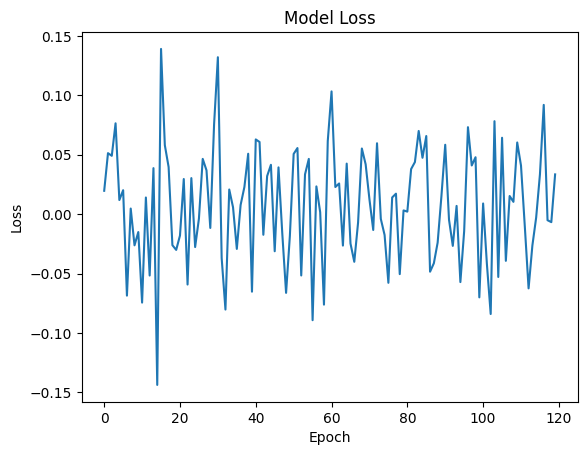

In [6]:
import matplotlib.pyplot as plt

# Access the history from the training output
history = ebm.fit(train_dataset, epochs=120)

# Plot the loss curve
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()